In [ ]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [ ]:
import pandas as pd
import numpy as np
import os
import django
from django.db.models import Max, Min, Avg, Q, F
from asgiref.sync import sync_to_async
import tqdm
from collections import defaultdict
from pandarallel import pandarallel
import requests
import json
from matplotlib import pyplot as plt

import ctypes
from ctypes import c_char_p, cdll
GoInt64 = ctypes.c_int64
GoInt = GoInt64
archive_node = "http://localhost:19545"

from etherscan.utils.parsing import ResponseParser as parser
pandarallel.initialize(progress_bar=True)
# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
# os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
# django.setup()

from debtmonitor.models import *
from datavisualization.models import *
from datastorage.models import *
from debtmonitor.help_function import *

import debtmonitor.views as dm
import datavisualization.views as dv
import datastorage.views as ds
import oracleWeb.views as ow

from debtmonitor.debt_function import *

import pickle

pandarallel.initialize(progress_bar=True)

# VAR predict

In [77]:
def gen_predict_hf(reserves_status, TargetContract, ReservesStatusEnd, StepAhead, MCAmount, ReservesStatusEndIndex, PreviousBlockForTrain):

    # reserves_status = get_reserves_status()
    latest_block_num = reserves_status['block_num'].max()
    interaction_df = get_interaction_data(TargetContract)

    until_block_num = latest_block_num
    until_block_num = ReservesStatusEnd
    until_index = ReservesStatusEndIndex

    until_block_n_index = combine_block_n_index({'block_num': until_block_num, 'index': until_index})
    # liquidation_index = until_index

    # Start Getting Data #####################################
    liquidation_df = get_liquidation_call(TargetContract)

    # reserves_status['variable_borrow_rate'] = reserves_status['variable_borrow_rate'].astype(int)
    # reserves_status['stable_borrow_rate'] = reserves_status['stable_borrow_rate'].astype(int)
    # reserves_status['liquidity_rate'] = reserves_status['liquidity_rate'].astype(int)
    # liquidation_df['debt_to_cover'] = liquidation_df['debt_to_cover'].astype(int)
    # liquidation_df['liquidated_collateral_amount'] = liquidation_df['liquidated_collateral_amount'].astype(int)
    # interaction_df['amount'] = interaction_df['amount'].astype(int)

    interaction_df = interaction_df['action block_num index on_behalf_of reserve amount rate_mode rate'.split(' ')].copy()
    reserves_status = reserves_status[[
        'reserve', 'block_num', 'index',  
        'liquidity_rate', 'stable_borrow_rate', 'variable_borrow_rate', 
        'liquidity_index','variable_borrow_index'
    ]].copy()
    liquidation_df = liquidation_df[[
        'block_num', 'index', 'on_behalf_of', 
        'collateral_asset', 'debt_asset', 'debt_to_cover', 'liquidated_collateral_amount',
        'liquidator', 'receive_atoken']].copy()

    interaction_df['block_n_index'] = interaction_df.apply(combine_block_n_index, axis=1)
    reserves_status['block_n_index'] = reserves_status.apply(combine_block_n_index, axis=1)
    liquidation_df['block_n_index'] = liquidation_df.apply(combine_block_n_index, axis=1)

    interaction_df = interaction_df.sort_values('block_n_index').reset_index(drop=True)
    reserves_status = reserves_status.sort_values('block_n_index').reset_index(drop=True)


    # just give a random reserve address, will be swich in the following part
    for index in interaction_df.index:
        if interaction_df.loc[index, 'action'] == "LiquidationCall":
            interaction_df.loc[index, 'reserve'] = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'

    # merge
    user_df = interaction_df.merge(reserves_status, on=['reserve'], how='left')
    change_token_address_to_name = lambda x: revert_token_dict[x] if x in revert_token_dict else x
    interaction_df['reserve'] = interaction_df['reserve'].apply(change_token_address_to_name).reset_index(drop=True)
    user_df['reserve'] = user_df['reserve'].apply(change_token_address_to_name).reset_index(drop=True)
    reserves_status['reserve'] = reserves_status['reserve'].apply(change_token_address_to_name).reset_index(drop=True)

    liquidation_df['collateral_asset'] = liquidation_df['collateral_asset'].apply(change_token_address_to_name)
    liquidation_df['debt_asset'] = liquidation_df['debt_asset'].apply(change_token_address_to_name)


    def get_liquidation_data(df_row):
        df_row = df_row.copy()
        if df_row['action'] != 'LiquidationCall': return df_row
        # collateral
        block_n_index_x = df_row['block_n_index_x']
        liquidation_row = liquidation_df[liquidation_df['block_n_index'] == block_n_index_x]
        collateral_asset = liquidation_row['collateral_asset'].values[0]
        tmp_reserves_status = reserves_status[\
            (reserves_status['reserve'] == collateral_asset) &\
            (reserves_status['block_n_index'] <= block_n_index_x)].copy().sort_values('block_n_index')
        tmp_reserves_status = tmp_reserves_status.iloc[-1, :]

        df_row['block_num_y'] = tmp_reserves_status['block_num']
        df_row['index_y'] = tmp_reserves_status['index']
        df_row['liquidity_rate'] = tmp_reserves_status['liquidity_rate']
        df_row['liquidity_index'] = tmp_reserves_status['liquidity_index']
        df_row['block_n_index_y'] = tmp_reserves_status['block_n_index']

        debt_asset = liquidation_row['debt_asset'].values[0]
        tmp_reserves_status = reserves_status[\
            (reserves_status['reserve'] == debt_asset) &\
            (reserves_status['block_n_index'] <= block_n_index_x)].copy().sort_values('block_n_index')
        tmp_reserves_status = tmp_reserves_status.iloc[-1, :]

        df_row['stable_borrow_rate'] = tmp_reserves_status['stable_borrow_rate']
        df_row['variable_borrow_rate'] = tmp_reserves_status['variable_borrow_rate']
        df_row['variable_borrow_index'] = tmp_reserves_status['variable_borrow_index']
        
        return df_row
    
    from_df = user_df[user_df['block_n_index_y'] <= user_df['block_n_index_x']]
    from_df = from_df.loc[from_df.groupby('block_n_index_x').block_n_index_y.idxmax()].reset_index(drop=True)
    from_df = from_df.apply(get_liquidation_data, axis=1)


    # a token
    collateral_dict = defaultdict(float)
    collatearl_able_dict = defaultdict(lambda :True)
    variable_debt_dict = defaultdict(float)
    stable_debt_dict = defaultdict(lambda : [None, None, None]) # amount, interest, start time

    sub_interaction_df = interaction_df[interaction_df['block_n_index'] <= until_block_n_index].copy()

    for index_i in sub_interaction_df.index:

        action_i = sub_interaction_df.loc[index_i, 'action']
        block_n_index = sub_interaction_df.loc[index_i, 'block_n_index']
        block_num = sub_interaction_df.loc[index_i, 'block_num']
        index = sub_interaction_df.loc[index_i, 'index']

        # block_time = get_block_time(block_num)
        before_data = from_df[from_df['block_n_index_x'] == block_n_index]#['amount'].values[0]
        liquidity_index = before_data['liquidity_index'].values[0]
        variable_borrow_index = before_data['variable_borrow_index'].values[0]
        stable_borrow_rate = before_data['stable_borrow_rate'].values[0]
        
        if action_i == "LiquidationCall":
            'collateral_asset', 'debt_asset', 'debt_to_cover', 'liquidated_collateral_amount',
            liquidation_i = liquidation_df[liquidation_df['block_n_index'] == block_n_index].copy().reset_index(drop=True)
            collateral_asset = liquidation_i.loc[0, 'collateral_asset']
            debt_asset = liquidation_i.loc[0, 'debt_asset']
            debt_to_cover = liquidation_i.loc[0, 'debt_to_cover']
            liquidated_collateral_amount = liquidation_i.loc[0, 'liquidated_collateral_amount']

            # a_token_amount_i = ray_div(liquidated_collateral_amount, liquidity_index)
            # collateral_dict[collateral_asset] -= a_token_amount_i

            collateral_in_original_unit, var_debt_in_original_unit, sta_debt_in_original_unit = get_token_value(
                block_num, index,
                collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict,reserves_status
            )

            if var_debt_in_original_unit[debt_asset] < debt_to_cover:
                var_debt_to_liquidate = var_debt_in_original_unit[debt_asset]
                sta_debt_to_repay = debt_to_cover - var_debt_to_liquidate
            else:
                var_debt_to_liquidate = debt_to_cover
                sta_debt_to_repay = 0

            success, remaining_token = update_target_debt_data(
                    "Repay", block_num, var_debt_to_liquidate, debt_asset, 
                    "2", liquidity_index, variable_borrow_index, stable_borrow_rate,
                    collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict
                )
            assert success

            if sta_debt_to_repay > 0:
                success, remaining_token = update_target_debt_data(
                    "Repay", block_num, sta_debt_to_repay, debt_asset, 
                    "1", liquidity_index, variable_borrow_index, stable_borrow_rate,
                    collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict
                )
                assert success
            
            success, remaining_token = update_target_debt_data(
                "Withdraw", block_num, liquidated_collateral_amount, collateral_asset, 
                "-1", liquidity_index, variable_borrow_index, stable_borrow_rate,
                collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict
            )
            assert success

        else:
            amount_i = sub_interaction_df.loc[index_i, 'amount']
            token_name_i = sub_interaction_df.loc[index_i, 'reserve']
            rate_mode_i = sub_interaction_df.loc[index_i, 'rate_mode']

            update_target_debt_data(action_i, block_num, amount_i, token_name_i, 
            rate_mode_i, liquidity_index, variable_borrow_index, stable_borrow_rate,
            collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict)
    
    
    token_value_dicts = get_token_value(until_block_num, until_index, 
                            collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict,
                            reserves_status,
                            fix_decimal=True
                        )

    # collateral, var_debt, sta_debt
    token_value_dicts = {i:j for i,j in zip(['collateral', 'var_debt', 'sta_debt'], token_value_dicts)}

    price_data = get_price_data(until_block_num, previous_block= 6424*1 + PreviousBlockForTrain)
    # price_data = get_price_data(until_block_num, previous_block=PreviousBlockForTrain)
    price_data['token0'] = price_data['token0'].apply(lambda x: 'weth' if x == 'eth' else x)
    price_data['token1'] = price_data['token1'].apply(lambda x: 'weth' if x == 'eth' else x)
    price_data = price_data[['block_num', 'oracle_name', 'token0', 'token1', 'current']]

    block_num_df = pd.DataFrame(
        range(
            price_data.block_num.min(), 
            until_block_num + 1
        ),
        columns=['block_num']
    )
    block_num_df.set_index('block_num', inplace=True)

    uniswapv3_price_dict = {}
    for token in ['usdt', 'dai', 'usdc']:
        sub_price_df = price_data[(price_data['oracle_name'] == 'uniswapv3') & (price_data['token1'] == token)].copy()
        sub_price_df[f'{token}'] = 1/sub_price_df['current']
        sub_price_df.set_index('block_num', inplace=True)
        sub_price_df = sub_price_df.merge(block_num_df, how='right', left_index=True, right_index=True)
        sub_price_df.fillna(method='ffill', inplace=True)
        sub_price_df.fillna(method='bfill', inplace=True)
        sub_price_df = sub_price_df[sub_price_df.index > (until_block_num-PreviousBlockForTrain-1)]
        uniswapv3_price_dict[token] = sub_price_df[token]
    chainlink_price_dict ={}
    for token in ['usdt', 'dai', 'usdc']:
        sub_price_df = price_data[(price_data['oracle_name'] == 'chainlink') & (price_data['token0'] == token)].copy()
        sub_price_df[f'{token}'] = sub_price_df['current']
        sub_price_df.set_index('block_num', inplace=True)
        sub_price_df = sub_price_df.merge(block_num_df, how='right', left_index=True, right_index=True)
        sub_price_df.fillna(method='ffill', inplace=True)
        sub_price_df.fillna(method='bfill', inplace=True)
        sub_price_df = sub_price_df[sub_price_df.index > (until_block_num-PreviousBlockForTrain-1)]
        chainlink_price_dict[token] = sub_price_df[token]

    used_token_list = []
    price_data_list = []
    price_name_list = []
    for asset_from in ['collateral', 'var_debt', 'sta_debt']:
        for token_name in ['usdc', 'usdt', 'dai']:
        # for token_name, token_amount in token_value_dicts[asset_from].items():
            if token_name == 'weth': continue
            if token_name not in used_token_list:
                used_token_list.append(token_name)
                price_data_list.append(chainlink_price_dict[token_name])
                price_name_list.append(f'chainlink_{token_name}')
                price_data_list.append(uniswapv3_price_dict[token_name])
                price_name_list.append(f'uniswapv3_{token_name}')
    var_train_df = pd.concat(price_data_list, axis=1)
    var_train_df.columns = price_name_list
    var_train_df = var_train_df.reset_index(drop=False)

    # hf_actual_series = cal_hf(var_train_df, token_value_dicts, liquidation_threshold_dict)
    # hf_actual_series.index = var_train_df['block_num']


    train_data = var_train_df.set_index('block_num')
    tmp_df = train_data.copy()
    log_f_diff = tmp_df.diff().dropna() 
    log_f_diff = log_f_diff.reset_index(drop=True)
    train_success = False

    trained_var = get_var_result(log_f_diff, maxlags=None)

    def mc_simulate(df, step=240):
        price_diff_prediction = pd.DataFrame(trained_var.simulate_var(step), columns=log_f_diff.columns)
        price_prediction = invert_transformation(tmp_df, price_diff_prediction) 
        hf_df = cal_hf(price_prediction, token_value_dicts, liquidation_threshold_dict)
        return hf_df

    mc_hf = pd.DataFrame(range(MCAmount)).apply(mc_simulate, args=(StepAhead,), axis=1).T
    horizontal_liquidation_pct = pd.DataFrame(mc_hf.apply(cal_pct_be_liquidated, axis=1), columns=['hf'])#.plot()
    # horizontal_liquidation_pct.columns = ['hf']
    horizontal_liquidation_pct['block_num'] = pd.Series(range(ReservesStatusEnd, ReservesStatusEnd + StepAhead))

    return horizontal_liquidation_pct

In [32]:
# GoInt64 = ctypes.c_int64
# GoInt = GoInt64

# # pandarallel.initialize(progress_bar=False)

# __library = cdll.LoadLibrary('../eth_crawler/library.so')
# get_aave_log = __library.get_aave_log
# get_aave_log.argtypes = [c_char_p, GoInt, GoInt]
# get_aave_log.restype = c_char_p

# res = get_aave_log(
#     # data_source.encode(), 
#     archive_node.encode(), 
#     GoInt(13054560), 
#     GoInt(13054560)
# )
# res

# Real HF cal

In [33]:
def gen_real_hf(reserves_status, TargetContract, ReservesStatusEnd, StepAhead, ReservesStatusEndIndex, PreviousBlockForTrain=0, print_info=False):

    # reserves_status = get_reserves_status()

    # StepAhead += PreviousBlockForTrain
    reserves_status = reserves_status.copy()
    
    latest_block_num = reserves_status['block_num'].max()
    interaction_df = get_interaction_data(TargetContract)

    until_block_num = latest_block_num
    until_block_num = ReservesStatusEnd
    until_index = ReservesStatusEndIndex

    reserves_status = reserves_status[reserves_status['block_num'] <= ReservesStatusEnd]
    until_block_n_index = combine_block_n_index({'block_num': until_block_num, 'index': until_index})
    # liquidation_index = until_index

    # Start Getting Data #####################################
    liquidation_df = get_liquidation_call(TargetContract)

    # reserves_status['variable_borrow_rate'] = reserves_status['variable_borrow_rate'].astype(int)
    # reserves_status['stable_borrow_rate'] = reserves_status['stable_borrow_rate'].astype(int)
    # reserves_status['liquidity_rate'] = reserves_status['liquidity_rate'].astype(int)
    # liquidation_df['debt_to_cover'] = liquidation_df['debt_to_cover'].astype(int)
    # liquidation_df['liquidated_collateral_amount'] = liquidation_df['liquidated_collateral_amount'].astype(int)
    # interaction_df['amount'] = interaction_df['amount'].astype(int)

    interaction_df = interaction_df['action block_num index on_behalf_of reserve amount rate_mode rate'.split(' ')].copy()
    reserves_status = reserves_status[[
        'reserve', 'block_num', 'index',  
        'liquidity_rate', 'stable_borrow_rate', 'variable_borrow_rate', 
        'liquidity_index','variable_borrow_index'
    ]].copy()
    liquidation_df = liquidation_df[[
        'block_num', 'index', 'on_behalf_of', 
        'collateral_asset', 'debt_asset', 'debt_to_cover', 'liquidated_collateral_amount',
        'liquidator', 'receive_atoken']].copy()

    interaction_df['block_n_index'] = interaction_df.apply(combine_block_n_index, axis=1)
    reserves_status['block_n_index'] = reserves_status.apply(combine_block_n_index, axis=1)
    liquidation_df['block_n_index'] = liquidation_df.apply(combine_block_n_index, axis=1)

    interaction_df = interaction_df.sort_values('block_n_index').reset_index(drop=True)
    reserves_status = reserves_status.sort_values('block_n_index').reset_index(drop=True)


    # just give a random reserve address, will be swich in the following part
    for index in interaction_df.index:
        if interaction_df.loc[index, 'action'] == "LiquidationCall":
            interaction_df.loc[index, 'reserve'] = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'

    # merge


    change_token_address_to_name = lambda x: revert_token_dict[x] if x in revert_token_dict else x
    interaction_df['reserve'] = interaction_df['reserve'].apply(change_token_address_to_name).reset_index(drop=True)
    reserves_status['reserve'] = reserves_status['reserve'].apply(change_token_address_to_name).reset_index(drop=True)
    liquidation_df['collateral_asset'] = liquidation_df['collateral_asset'].apply(change_token_address_to_name)
    liquidation_df['debt_asset'] = liquidation_df['debt_asset'].apply(change_token_address_to_name)


    collateral_dict = defaultdict(float)
    collatearl_able_dict = defaultdict(lambda :True)
    variable_debt_dict = defaultdict(float)
    stable_debt_dict = defaultdict(lambda : [None, None, None]) # amount, interest, start time

    if print_info: print(interaction_df)

    sub_interaction_df = interaction_df[interaction_df['block_n_index'] <= until_block_n_index].copy()
    curent_block_index = 0
    hf_list = []
    block_list = []
    have_data = False
    block_n_index = None
    interaction_block_list = sub_interaction_df['block_num'].to_list()
    
    # for tmp_block_num in tqdm.tqdm(reserves_status['block_num'].unique()):
    for tmp_block_num in tqdm.tqdm(range(reserves_status['block_num'].min(), ReservesStatusEnd + StepAhead)):
        if tmp_block_num not in interaction_block_list and tmp_block_num < (ReservesStatusEnd - PreviousBlockForTrain):
            continue
        until_block_num = tmp_block_num
        tmp_reserves_status = reserves_status[reserves_status['block_num'] <= tmp_block_num]#.copy()
        tmp_index = 9999
        tmp_block_n_index = combine_block_n_index(dict(block_num=tmp_block_num, index=tmp_index))
        sub_interaction_df = interaction_df[(interaction_df['block_n_index'] > curent_block_index) & (interaction_df['block_n_index'] <= tmp_block_n_index)].copy()
        
        update_value = False
        for index_i in sub_interaction_df.index:
            update_value = True
            if print_info: print(sub_interaction_df.loc[index_i, :])
            if print_info: print(tmp_reserves_status.iloc[-2:,:])
            have_data = True
            action_i = sub_interaction_df.loc[index_i, 'action']
            block_n_index = sub_interaction_df.loc[index_i, 'block_n_index']
            block_num = sub_interaction_df.loc[index_i, 'block_num']
            index = sub_interaction_df.loc[index_i, 'index']

            # block_time = get_block_time(block_num)
            # before_data = from_df[from_df['block_n_index_x'] == block_n_index]#['amount'].values[0]
            # liquidity_index = tmp_reserves_status['liquidity_index'].values[-1]
            # variable_borrow_index = tmp_reserves_status['variable_borrow_index'].values[0]
            # stable_borrow_rate = tmp_reserves_status['stable_borrow_rate'].values[0]
            
            if action_i == "LiquidationCall":
                'collateral_asset', 'debt_asset', 'debt_to_cover', 'liquidated_collateral_amount',
                liquidation_i = liquidation_df[liquidation_df['block_n_index'] == block_n_index].copy().reset_index(drop=True)
                if print_info: print(liquidation_i)
                collateral_asset = liquidation_i.loc[0, 'collateral_asset']
                debt_asset = liquidation_i.loc[0, 'debt_asset']
                debt_to_cover = liquidation_i.loc[0, 'debt_to_cover']
                liquidated_collateral_amount = liquidation_i.loc[0, 'liquidated_collateral_amount']

                liquidity_index = tmp_reserves_status[(tmp_reserves_status['reserve']==collateral_asset) & (tmp_reserves_status['block_n_index']<=block_n_index)]['liquidity_index'].values[-1]
                variable_borrow_index = tmp_reserves_status[(tmp_reserves_status['reserve']==debt_asset) & (tmp_reserves_status['block_n_index']<=block_n_index)]['variable_borrow_index'].values[-1]
                stable_borrow_rate = tmp_reserves_status[(tmp_reserves_status['reserve']==debt_asset) & (tmp_reserves_status['block_n_index']<=block_n_index)]['stable_borrow_rate'].values[-1]

                # a_token_amount_i = ray_div(liquidated_collateral_amount, liquidity_index)
                # collateral_dict[collateral_asset] -= a_token_amount_i

                collateral_in_original_unit, var_debt_in_original_unit, sta_debt_in_original_unit = get_token_value(
                    block_num, index,
                    collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict,reserves_status
                )

                if var_debt_in_original_unit[debt_asset] < debt_to_cover:
                    var_debt_to_liquidate = var_debt_in_original_unit[debt_asset]
                    sta_debt_to_repay = debt_to_cover - var_debt_to_liquidate
                else:
                    var_debt_to_liquidate = debt_to_cover
                    sta_debt_to_repay = 0

                success, remaining_token = update_target_debt_data(
                        "Repay", block_num, var_debt_to_liquidate, debt_asset, 
                        "2", liquidity_index, variable_borrow_index, stable_borrow_rate,
                        collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict
                    )
                assert success

                if sta_debt_to_repay > 0:
                    success, remaining_token = update_target_debt_data(
                        "Repay", block_num, sta_debt_to_repay, debt_asset, 
                        "1", liquidity_index, variable_borrow_index, stable_borrow_rate,
                        collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict
                    )
                    assert success
                
                success, remaining_token = update_target_debt_data(
                    "Withdraw", block_num, liquidated_collateral_amount, collateral_asset, 
                    "-1", liquidity_index, variable_borrow_index, stable_borrow_rate,
                    collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict
                )
                assert success

            else:
                amount_i = sub_interaction_df.loc[index_i, 'amount']
                token_name_i = sub_interaction_df.loc[index_i, 'reserve']
                rate_mode_i = sub_interaction_df.loc[index_i, 'rate_mode']

                liquidity_index = tmp_reserves_status[(tmp_reserves_status['reserve']==token_name_i) & (tmp_reserves_status['block_n_index']<=block_n_index)]['liquidity_index'].values[-1]
                variable_borrow_index = tmp_reserves_status[(tmp_reserves_status['reserve']==token_name_i) & (tmp_reserves_status['block_n_index']<=block_n_index)]['variable_borrow_index'].values[-1]
                stable_borrow_rate = tmp_reserves_status[(tmp_reserves_status['reserve']==token_name_i) & (tmp_reserves_status['block_n_index']<=block_n_index)]['stable_borrow_rate'].values[-1]

                update_target_debt_data(action_i, block_num, amount_i, token_name_i, 
                rate_mode_i, liquidity_index, variable_borrow_index, stable_borrow_rate,
                collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict)
            # print(sub_interaction_df.loc[index_i, :])
            
            if print_info: print("liquidity_index, variable_borrow_index, stable_borrow_rate")
            if print_info: print(liquidity_index, variable_borrow_index, stable_borrow_rate)
            if print_info: print("collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict")
            if print_info: print(collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict)
            
            if print_info: print('---------------------------------------------------------------')
        
        if update_value:
            if print_info: print(get_token_value(until_block_num, until_index, 
                                collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict,
                                reserves_status,
                                fix_decimal=True
                            ))

        if block_n_index is None:
            continue
        curent_block_index = block_n_index
        
        # if not have_data: continue
        if len(variable_debt_dict) == 0 and len(stable_debt_dict) == 0: continue
        # if : continue
        # print(tmp_block_num)
        if tmp_block_num < (ReservesStatusEnd - PreviousBlockForTrain): continue
        # print(999)
        if tmp_block_num > (ReservesStatusEnd + StepAhead): break

        
        token_value_dicts = get_token_value(until_block_num, until_index, 
                                collateral_dict, collatearl_able_dict, variable_debt_dict, stable_debt_dict,
                                reserves_status,
                                fix_decimal=True
                            )

        # collateral, var_debt, sta_debt
        token_value_dicts = {i:j for i,j in zip(['collateral', 'var_debt', 'sta_debt'], token_value_dicts)}
        if print_info: print(token_value_dicts)

        price_data = get_price_data(until_block_num, previous_block= 6424*1)
        # price_data = get_price_data(until_block_num, previous_block=PreviousBlockForTrain)
        price_data['token0'] = price_data['token0'].apply(lambda x: 'weth' if x == 'eth' else x)
        price_data['token1'] = price_data['token1'].apply(lambda x: 'weth' if x == 'eth' else x)
        price_data = price_data[['block_num', 'oracle_name', 'token0', 'token1', 'current']]

        block_num_df = pd.DataFrame(
            range(
                price_data.block_num.min(), 
                until_block_num + 1
            ),
            columns=['block_num']
        )
        block_num_df.set_index('block_num', inplace=True)

        uniswapv3_price_dict = {}
        for token in ['usdt', 'dai', 'usdc']:
            sub_price_df = price_data[(price_data['oracle_name'] == 'uniswapv3') & (price_data['token1'] == token)].copy()
            sub_price_df[f'{token}'] = 1/sub_price_df['current']
            sub_price_df.set_index('block_num', inplace=True)
            sub_price_df = sub_price_df.merge(block_num_df, how='right', left_index=True, right_index=True)
            sub_price_df.fillna(method='ffill', inplace=True)
            sub_price_df.fillna(method='bfill', inplace=True)
            sub_price_df = sub_price_df[sub_price_df.index > (until_block_num-10)]
            uniswapv3_price_dict[token] = sub_price_df[token]
        chainlink_price_dict ={}
        for token in ['usdt', 'dai', 'usdc']:
            sub_price_df = price_data[(price_data['oracle_name'] == 'chainlink') & (price_data['token0'] == token)].copy()
            sub_price_df[f'{token}'] = sub_price_df['current']
            sub_price_df.set_index('block_num', inplace=True)
            sub_price_df = sub_price_df.merge(block_num_df, how='right', left_index=True, right_index=True)
            sub_price_df.fillna(method='ffill', inplace=True)
            sub_price_df.fillna(method='bfill', inplace=True)
            sub_price_df = sub_price_df[sub_price_df.index > (until_block_num-10)]
            chainlink_price_dict[token] = sub_price_df[token]

        used_token_list = []
        price_data_list = []
        price_name_list = []
        for asset_from in ['collateral', 'var_debt', 'sta_debt']:
            for token_name in ['usdc', 'usdt', 'dai']:
            # for token_name, token_amount in token_value_dicts[asset_from].items():
                if token_name == 'weth': continue
                if token_name not in used_token_list:
                    used_token_list.append(token_name)
                    price_data_list.append(chainlink_price_dict[token_name])
                    price_name_list.append(f'chainlink_{token_name}')
                    price_data_list.append(uniswapv3_price_dict[token_name])
                    price_name_list.append(f'uniswapv3_{token_name}')

        var_train_df = pd.concat(price_data_list, axis=1)
        var_train_df.columns = price_name_list
        var_train_df = var_train_df.reset_index(drop=False)

        hf_actual_series = cal_hf(var_train_df, token_value_dicts, liquidation_threshold_dict)
        block_list.append(tmp_block_num)
        hf_list.append(hf_actual_series.iloc[-1])
    
    
    hf_df = pd.DataFrame({'block_num': block_list, 'hf': hf_list})
    return hf_df

# Get Liquidation Data

In [ ]:
change_token_address_to_name = lambda x: revert_token_dict[x] if x in revert_token_dict else x
reserves_status = get_reserves_status()
liquidation_data = get_liquidation_call()
liquidation_data = liquidation_data.iloc[:,2:]

np.random.seed(99)
liquidation_data = liquidation_data.loc[np.random.choice(liquidation_data.index, 1000)]
i = 0
price_data_start_from = 12469311
def vaidate_data(df_row):
    interaction_df = get_interaction_data(df_row.loc['on_behalf_of'])
    token_ok = interaction_df['reserve'].apply(change_token_address_to_name).apply(lambda x: len(x) <= 10).all()
    collateral_ok = interaction_df[interaction_df['action']=='Deposit']['reserve'].apply(change_token_address_to_name).apply(lambda x: x != 'usdt').all()
    no_swap = interaction_df['action'].apply(lambda x: x != 'Swap').all()
    have_price_data = interaction_df['block_num'].apply(lambda x: x > price_data_start_from).all()
    return token_ok and collateral_ok and no_swap and have_price_data
valid_data_bool = liquidation_data.parallel_apply(vaidate_data, axis=1)
liquidation_data_ok = liquidation_data[valid_data_bool]
liquidation_data_ok = liquidation_data_ok.reset_index(drop=True).iloc[:100,:]
liquidation_data_ok

# Test

In [ ]:
i = 3
step_ahead = 10
step_before = -1
mc_amount = 100
reserves_status_end_index = 9999
# previous_block_for_train = 10


tmp_data = liquidation_data_ok.iloc[i,:]

hf_list = gen_real_hf(
    reserves_status[(reserves_status['block_num']>(13550124-6424)) & (reserves_status['block_num']<tmp_data['block_num'] - step_before)],
    TargetContract = tmp_data['on_behalf_of'],
    ReservesStatusEnd = tmp_data['block_num'] - step_before,
    StepAhead = step_ahead,
    ReservesStatusEndIndex = reserves_status_end_index,
    # PreviousBlockForTrain = previous_block_for_train
)
tmp_block_num, hf_list = hf_list

In [ ]:
i = 8
step_ahead = 200
reserves_status_end_index = 9999

tmp_data = liquidation_data_ok.iloc[i,:]

hf_list = gen_real_hf(
    reserves_status[reserves_status['block_num']<15366765],
    TargetContract = tmp_data['on_behalf_of'],
    ReservesStatusEnd = 15366765,
    StepAhead = step_ahead,
    ReservesStatusEndIndex = reserves_status_end_index,
    print_info=False
)
tmp_block_num, hf_list = hf_list

In [ ]:
pd.DataFrame(hf_list).plot()

# Evaluation

In [ ]:
tmp_data

In [ ]:
liquidation_data_ok

In [ ]:
# step_ahead = 1
# reserves_status_end_index = 9999
# mc_amount = 11
# pre_block_train = 1

# def test_valid_data(df_row):
#     reserves_status_end = df_row['block_num']
#     try:
#         hf_df = gen_real_hf(
#             reserves_status,
#             TargetContract = df_row['on_behalf_of'],
#             ReservesStatusEnd = reserves_status_end,
#             StepAhead = step_ahead,
#             ReservesStatusEndIndex = reserves_status_end_index,
#             PreviousBlockForTrain = pre_block_train, 
#             print_info=False
#         )
#         return True
#     except AssertionError:
#         return False

# valid_df = liquidation_data_ok.parallel_apply(test_valid_data, axis=1)
# valid_df

In [ ]:
step_ahead = 1
reserves_status_end_index = 9999
mc_amount = 1
pre_block_train = 1
data_i_list = []

for i in range(liquidation_data_ok.shape[0]):
    print(i)
    tmp_data = liquidation_data_ok.iloc[i,:]
    reserves_status_end = tmp_data['block_num']
    try:
        hf_df = gen_real_hf(
            reserves_status,
            TargetContract = tmp_data['on_behalf_of'],
            ReservesStatusEnd = reserves_status_end,
            StepAhead = step_ahead,
            ReservesStatusEndIndex = reserves_status_end_index,
            PreviousBlockForTrain = pre_block_train, 
            print_info=False
        )
    except AssertionError:
        continue
    data_i_list.append(i)

In [ ]:
liquidation_data_evl = liquidation_data_ok.iloc[data_i_list,:]

In [ ]:
liquidation_data_evl.to_csv('evl.csv')

In [ ]:
liquidation_data_evl

In [ ]:
len(data_i_list)

In [ ]:
step_ahead = 200
reserves_status_end_index = 9999
mc_amount = 100
pre_block_train = 1000
# data_i_list = []
data_list = []

for i in data_i_list[:10]:
    
    tmp_data = liquidation_data_ok.iloc[i,:]
    reserves_status_end = tmp_data['block_num']

    try:
        hf_df = gen_real_hf(
            reserves_status,
            TargetContract = tmp_data['on_behalf_of'],
            ReservesStatusEnd = reserves_status_end,
            StepAhead = step_ahead,
            ReservesStatusEndIndex = reserves_status_end_index,
            PreviousBlockForTrain = pre_block_train, 
            print_info=False
        )
    except AssertionError:
        continue
    # data_i_list.append(i)

    sim_hf_df = gen_predict_hf(
        reserves_status,
        TargetContract = tmp_data['on_behalf_of'], 
        ReservesStatusEnd = reserves_status_end,
        StepAhead = step_ahead, 
        MCAmount = mc_amount, 
        ReservesStatusEndIndex = reserves_status_end_index, 
        PreviousBlockForTrain = pre_block_train,
    )
    data_list.append(hf_df, sim_hf_df)

In [24]:
hf_df

,block_num,hf
0,14955725,1.006450
1,14955726,1.096985


In [94]:
step_ahead = 1010
reserves_status_end_index = 9999
mc_amount = 100
pre_block_train = 1000
end_before = 500#1000
def apply_real_hf(df_row):
    reserves_status_end = df_row['block_num']
    hf_df = gen_real_hf(
        reserves_status,
        TargetContract = df_row['on_behalf_of'],
        ReservesStatusEnd = reserves_status_end - end_before,
        StepAhead = step_ahead,
        ReservesStatusEndIndex = reserves_status_end_index,
        PreviousBlockForTrain = pre_block_train, 
        print_info=False
    )
    return ','.join(map(str, hf_df['block_num'].to_list())) + ';' + ','.join(map(str, hf_df['hf'].to_list()))
def apply_sim_hf(df_row):
    reserves_status_end = df_row['block_num']
    sim_hf_df = gen_predict_hf(
        reserves_status,
        TargetContract = df_row['on_behalf_of'], 
        ReservesStatusEnd = reserves_status_end - end_before,
        StepAhead = step_ahead, 
        MCAmount = mc_amount, 
        ReservesStatusEndIndex = reserves_status_end_index, 
        PreviousBlockForTrain = pre_block_train,
    )
    return ','.join(map(str, sim_hf_df['block_num'].to_list())) + ';' + ','.join(map(str, sim_hf_df['hf'].to_list()))


In [90]:
liquidation_data_evl = liquidation_data_evl.reset_index(drop=True)
liquidation_data_evl[liquidation_data_evl.index != 76]

,index,on_behalf_of,collateral_asset,debt_asset,debt_to_cover,liquidated_collateral_amount,liquidator,receive_atoken,transaction_hash,block_num
76,32,0x846b4e00ef954ab1fefc326716c9c1db8d40a8eb,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6b175474e89094c44da98b954eedeac495271d0f,1.821750e+20,1.841077e+17,0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832,False,,15062348


In [95]:
sim_hf_result = liquidation_data_evl.iloc[:-10].parallel_apply(apply_sim_hf, axis=1)

with open('../data/sim_hf_result500.pickle', 'wb') as handle:
    pickle.dump(sim_hf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
a

In [92]:
sim_hf_result = liquidation_data_evl.iloc[:-10].parallel_apply(apply_sim_hf, axis=1)

with open('../data/sim_hf_result.pickle', 'wb') as handle:
    pickle.dump(sim_hf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
a

<AxesSubplot:>

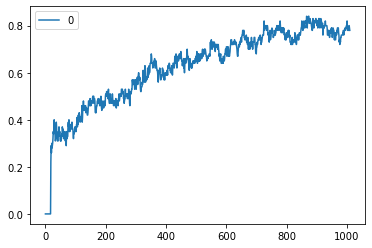

In [82]:
pd.DataFrame(map(float, sim_hf_result[4].split(';')[1].split(','))).plot()

In [93]:
tqdm.tqdm.pandas()
# sim_hf_result = liquidation_data_evl.progress_apply(apply_sim_hf, axis=1)
hf_result = liquidation_data_evl.iloc[:-10].parallel_apply(apply_real_hf, axis=1)

with open('../data/real_hf_result.pickle', 'wb') as handle:
    pickle.dump(hf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)


100%|██████████████████████████████████████████████████████| 1908618/1908618 [19:46<00:00, 1608.02it/s]


In [72]:
hf_result

0    15195242,15195243,15195244,15195245,15195246,1...
1    14943366,14943367,14943368,14943369,14943370,1...
2    14190396,14190397,14190398,14190399,14190400,1...
3    14959335,14959336,14959337,14959338,14959339,1...
4    14741863,14741864,14741865,14741866,14741867,1...
5    14841317,14841318,14841319,14841320,14841321,1...
6    13004196,13004197,13004198,13004199,13004200,1...
8    14759337,14759338,14759339,14759340,14759341,1...
dtype: object

<AxesSubplot:>

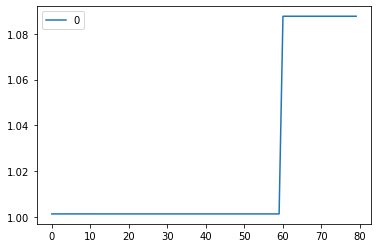

In [75]:
pd.DataFrame(map(float, hf_result[4].split(';')[1].split(','))).plot()

In [97]:
with open('../data/sim_hf_result500.pickle', 'rb') as handle:
    sim_hf_result500 = pickle.load(handle)
with open('../data/sim_hf_result.pickle', 'rb') as handle:
    sim_hf_result1000 = pickle.load(handle)
with open('../data/real_hf_result.pickle', 'rb') as handle:
    hf_result = pickle.load(handle)

In [99]:
liquidation_data_evl

,index,on_behalf_of,collateral_asset,debt_asset,debt_to_cover,liquidated_collateral_amount,liquidator,receive_atoken,transaction_hash,block_num
0,14,0x108f7dc6f6fb9687a5bfbe5c1b03156028bd52d6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,1.212201e+08,8.266455e+16,0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832,False,,15195302
1,240,0x9318ad433e97a01ac03524a880b9310b0237caac,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,3.710011e+09,2.409062e+18,0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a,False,,14943426
2,332,0xab778d96cd14d4bfb993934b9c3a71fc3ae615bf,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7,8.621875e+08,3.087579e+17,0xd911560979b78821d7b045c79e36e9cbfc2f6c6f,True,,14190456
3,195,0x2537077ee24e64db9799606e97f4b7fe44cf9a82,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,1.815802e+09,1.745480e+18,0xd911560979b78821d7b045c79e36e9cbfc2f6c6f,True,,14959395
4,505,0x1a917efa58143e2599a9074fccaa8a8031fdc13c,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2.119142e+10,9.226824e+18,0x8ceb117f98cebf18b3fb97181a8a2067fad700d7,False,,14741923
...,...,...,...,...,...,...,...,...,...,...
80,300,0x5c7b495b19e083fed10855e304df4a66cf15cfe8,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6b175474e89094c44da98b954eedeac495271d0f,1.536526e+21,8.374072e+17,0xd911560979b78821d7b045c79e36e9cbfc2f6c6f,True,,14763363
81,19,0x5896912b678322baca6dba07d3849fb0d97d6f0d,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7,1.325075e+08,1.164817e+17,0x8472ee188899569cf6ef42bb2038facae66972d2,False,,15152568
82,109,0x033cd5e8044222388366889cffe8194da1c4769f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7,7.785159e+08,5.146645e+17,0xd911560979b78821d7b045c79e36e9cbfc2f6c6f,True,,14943490
83,131,0x5e9f1d6a322e1297981f967b2ac86f5ee70348a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7,7.226605e+08,4.777393e+17,0xd911560979b78821d7b045c79e36e9cbfc2f6c6f,True,,14943490


In [128]:
def revert_str_to_df(df_row):
    data = map(float, df_row.split(';')[1].split(','))
    block_num = map(int, df_row.split(';')[0].split(','))
    return pd.DataFrame(data, index=block_num)
predict_hf500_list = []
for i in sim_hf_result500.index:
    liquidation_i = liquidation_data_evl.iloc[i]
    hf_sim = revert_str_to_df(sim_hf_result500.iloc[i])
    predict_hf500_list.append([liquidation_i, hf_sim])
predict_hf1000_list = []
for i in sim_hf_result1000.index:
    liquidation_i = liquidation_data_evl.iloc[i]
    hf_sim = revert_str_to_df(sim_hf_result500.iloc[i])
    predict_hf1000_list.append([liquidation_i, hf_sim])
real_hf_list = []
for i in sim_hf_result1000.index:
    liquidation_i = liquidation_data_evl.iloc[i]
    hf_real = revert_str_to_df(hf_result.iloc[i])
    real_hf_list.append([liquidation_i, hf_real])

In [150]:
avaliable_data = []
for i in range(len(real_hf_list)):
    if real_hf_list[i][1].iloc[0, 0] < 1:
        continue
    avaliable_data.append([real_hf_list[i], predict_hf500_list[i], predict_hf1000_list[i]])
    # predict_hf500_list[i][1].plot()
    # real_hf_list[i][1].plot()

In [152]:
avaliable_data[0]

[[index                                                                  240
  on_behalf_of                    0x9318ad433e97a01ac03524a880b9310b0237caac
  collateral_asset                0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
  debt_asset                      0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
  debt_to_cover                                                 3710011126.0
  liquidated_collateral_amount                         2409062334567966208.0
  liquidator                      0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a
  receive_atoken                                                       False
  transaction_hash                                                          
  block_num                                                         14943426
  Name: 1, dtype: object,
                   0
  14941426  1.032292
  14941427  1.032292
  14941428  1.032292
  14941429  1.032291
  14941430  1.032291
  ...            ...
  14943431  1.077574
  14943432  1.077574
  14943433  1.0